In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jun  8 18:41:46 2020

@author: Jonathan.Venezia@ibm.com
"""

import os
import sys
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

COLORS = ["darkorange","royalblue","slategrey"]

def fetch_data(data_dir):
    """
    laod all json formatted files into a dataframe
    """

    ## input testing
    if not os.path.isdir(data_dir):
        raise Exception("specified data dir does not exist")
    if not len(os.listdir(data_dir)) > 0:
        raise Exception("specified data dir does not contain any files")

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']

    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    years,months,days = df['year'].values,df['month'].values,df['day'].values 
    dates = ["{}-{}-{}".format(years[i],str(months[i]).zfill(2),str(days[i]).zfill(2)) for i in range(df.shape[0])]
    df['invoice_date'] = np.array(dates,dtype='datetime64[D]')
    df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return(df)


def convert_to_ts(df_orig, country=None):
    """
    given the original DataFrame (fetch_data())
    return a numerically indexed time-series DataFrame 
    by aggregating over each day
    """

    if country:
        if country not in np.unique(df_orig['country'].values):
            raise Exception("country not found")
    
        mask = df_orig['country'] == country
        df = df_orig[mask]
    else:
        df = df_orig
        
    ## use a date range to ensure all days are accounted for in the data
    invoice_dates = df['invoice_date'].values
    start_month = '{}-{}'.format(df['year'].values[0],str(df['month'].values[0]).zfill(2))
    stop_month = '{}-{}'.format(df['year'].values[-1],str(df['month'].values[-1]).zfill(2))
    df_dates = df['invoice_date'].values.astype('datetime64[D]')
    days = np.arange(start_month,stop_month,dtype='datetime64[D]')
    
    purchases = np.array([np.where(df_dates==day)[0].size for day in days])
    invoices = [np.unique(df[df_dates==day]['invoice'].values).size for day in days]
    streams = [np.unique(df[df_dates==day]['stream_id'].values).size for day in days]
    views =  [df[df_dates==day]['times_viewed'].values.sum() for day in days]
    revenue = [df[df_dates==day]['price'].values.sum() for day in days]
    year_month = ["-".join(re.split("-",str(day))[:2]) for day in days]

    df_time = pd.DataFrame({'date':days,
                            'purchases':purchases,
                            'unique_invoices':invoices,
                            'unique_streams':streams,
                            'total_views':views,
                            'year_month':year_month,
                            'revenue':revenue})
    return(df_time)


def fetch_ts(data_dir, clean=False):
    """
    convenience function to read in new data
    uses csv to load quickly
    use clean=True when you want to re-create the files
    """

    ts_data_dir = os.path.join(data_dir,"ts-data")
    
    if clean:
        shutil.rmtree(ts_data_dir)
    if not os.path.exists(ts_data_dir):
        os.mkdir(ts_data_dir)

    ## if files have already been processed load them        
    if len(os.listdir(ts_data_dir)) > 0:
        print("... loading ts data from files")
        return({re.sub("\.csv","",cf)[3:]:pd.read_csv(os.path.join(ts_data_dir,cf)) for cf in os.listdir(ts_data_dir)})

    ## get original data
    print("... processing data for loading")
    df = fetch_data(data_dir)

    ## find the top ten countries (wrt revenue)
    table = pd.pivot_table(df,index='country',values="price",aggfunc='sum')
    table.columns = ['total_revenue']
    table.sort_values(by='total_revenue',inplace=True,ascending=False)
    top_ten_countries =  np.array(list(table.index))[:10]

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    countries = [os.path.join(data_dir,"ts-"+re.sub("\s+","_",c.lower()) + ".csv") for c in top_ten_countries]

    ## load the data
    dfs = {}
    dfs['all'] = convert_to_ts(df)
    for country in top_ten_countries:
        country_id = re.sub("\s+","_",country.lower())
        file_name = os.path.join(data_dir,"ts-"+ country_id + ".csv")
        dfs[country_id] = convert_to_ts(df,country=country)

    ## save the data as csvs    
    for key, item in dfs.items():
        item.to_csv(os.path.join(ts_data_dir,"ts-"+key+".csv"),index=False)
        
    return(dfs)

def engineer_features(df,training=True):
    """
    for any given day the target becomes the sum of the next days revenue
    for that day we engineer several features that help predict the summed revenue
    
    the 'training' flag will trim data that should not be used for training
    when set to false all data will be returned

    """

    ## extract dates
    dates = df['date'].values.copy()
    dates = dates.astype('datetime64[D]')

    ## engineer some features
    eng_features = defaultdict(list)
    previous =[7, 14, 28, 70]  #[7, 14, 21, 28, 35, 42, 49, 56, 63, 70]
    y = np.zeros(dates.size)
    for d,day in enumerate(dates):

        ## use windows in time back from a specific date
        for num in previous:
            current = np.datetime64(day, 'D') 
            prev = current - np.timedelta64(num, 'D')
            mask = np.in1d(dates, np.arange(prev,current,dtype='datetime64[D]'))
            eng_features["previous_{}".format(num)].append(df[mask]['revenue'].sum())

        ## get get the target revenue    
        plus_30 = current + np.timedelta64(30,'D')
        mask = np.in1d(dates, np.arange(current,plus_30,dtype='datetime64[D]'))
        y[d] = df[mask]['revenue'].sum()

        ## attempt to capture monthly trend with previous years data (if present)
        start_date = current - np.timedelta64(365,'D')
        stop_date = plus_30 - np.timedelta64(365,'D')
        mask = np.in1d(dates, np.arange(start_date,stop_date,dtype='datetime64[D]'))
        eng_features['previous_year'].append(df[mask]['revenue'].sum())

        ## add some non-revenue features
        minus_30 = current - np.timedelta64(30,'D')
        mask = np.in1d(dates, np.arange(minus_30,current,dtype='datetime64[D]'))
        eng_features['recent_invoices'].append(df[mask]['unique_invoices'].mean())
        eng_features['recent_views'].append(df[mask]['total_views'].mean())

    X = pd.DataFrame(eng_features)
    ## combine features in to df and remove rows with all zeros
    X.fillna(0,inplace=True)
    mask = X.sum(axis=1)>0
    X = X[mask]
    y = y[mask]
    dates = dates[mask]
    X.reset_index(drop=True, inplace=True)

    if training == True:
        ## remove the last 30 days (because the target is not reliable)
        mask = np.arange(X.shape[0]) < np.arange(X.shape[0])[-30]
        X = X[mask]
        y = y[mask]
        dates = dates[mask]
        X.reset_index(drop=True, inplace=True)
    
    return(X,y,dates)

In [3]:
df = fetch_data('./cs-train/')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815011 entries, 0 to 815010
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   country       815011 non-null  object        
 1   customer_id   625249 non-null  float64       
 2   day           815011 non-null  int64         
 3   invoice       815011 non-null  object        
 4   month         815011 non-null  int64         
 5   price         815011 non-null  float64       
 6   stream_id     815011 non-null  object        
 7   times_viewed  815011 non-null  int64         
 8   year          815011 non-null  int64         
 9   invoice_date  815011 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 62.2+ MB


In [5]:
df.describe()

,customer_id,day,month,price,times_viewed,year
count,625249.000000,815011.000000,815011.000000,815011.000000,815011.000000,815011.000000
mean,15333.415068,15.064819,6.592718,4.802631,5.231106,2018.247654
std,1698.360788,8.788845,3.598781,135.058707,5.109982,0.545261
min,12346.000000,1.000000,1.000000,-53594.360000,0.000000,2017.000000
25%,13956.000000,7.000000,3.000000,1.250000,1.000000,2018.000000
50%,15279.000000,15.000000,6.000000,2.100000,3.000000,2018.000000
75%,16813.000000,23.000000,10.000000,4.210000,8.000000,2019.000000
max,18287.000000,31.000000,12.000000,38970.000000,24.000000,2019.000000


In [6]:
df.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,17998.0,28,489562,11,5.95,84656,1,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


In [23]:
time_range = df['invoice_date'].max() - df['invoice_date'].min()
time_range

Timedelta('610 days 00:00:00')

In [15]:
country_totals = df.groupby('country').sum().sort_values(by='price',ascending = False)

In [16]:
country_totals

,customer_id,day,month,price,times_viewed,year
country,,,,,,
United Kingdom,8.770331e+09,11294245,4967307,3.521514e+06,3725703,1516160498
EIRE,1.781244e+08,214425,89337,1.070692e+05,111636,27401294
Germany,1.683921e+08,203006,81741,4.927182e+04,112618,26916270
France,1.245792e+08,139287,62335,4.056514e+04,83124,19979533
Norway,1.002374e+07,12753,7108,3.849475e+04,7881,1606587
Spain,3.335718e+07,37596,15379,1.604099e+04,19573,5259924
Hong Kong,0.000000e+00,4173,1114,1.445257e+04,2635,557168
Portugal,2.212917e+07,27623,13032,1.352867e+04,14195,3663166
Singapore,3.950640e+06,3578,1702,1.317592e+04,3042,625773


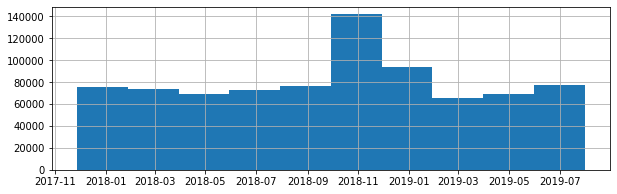

In [11]:
plt.figure(figsize=(10,3))
df.invoice_date.hist()

In [27]:
ts_df = convert_to_ts(df)
uk_df = convert_to_ts(df, 'United Kingdom')

In [31]:
uk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             607 non-null    datetime64[ns]
 1   purchases        607 non-null    int64         
 2   unique_invoices  607 non-null    int64         
 3   unique_streams   607 non-null    int64         
 4   total_views      607 non-null    int64         
 5   year_month       607 non-null    object        
 6   revenue          607 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 33.3+ KB


In [32]:
uk_df.describe()

,purchases,unique_invoices,unique_streams,total_views,revenue
count,607.000000,607.000000,607.000000,607.000000,607.000000
mean,1174.853377,61.616145,625.401977,5819.052718,5508.322313
std,955.229273,44.501559,394.929437,4455.524206,10030.548944
min,0.000000,0.000000,0.000000,0.000000,-45645.329000
25%,574.500000,25.500000,420.500000,2533.500000,1731.520000
50%,1183.000000,64.000000,718.000000,5964.000000,4279.070000
75%,1594.500000,90.000000,891.000000,8095.000000,6807.370000
max,7638.000000,207.000000,1568.000000,28444.000000,169539.620000


In [33]:
X,y,dates = engineer_features(uk_df)

In [44]:
X

,previous_7,previous_14,previous_28,previous_70,previous_year,recent_invoices,recent_views
0,13281.12,13281.12,13281.12,13281.120,0.00,5.500000,461.500000
1,26504.09,26504.09,26504.09,26504.090,0.00,9.620690,916.275862
2,39445.59,39445.59,39445.59,39445.590,0.00,14.100000,1393.833333
3,48608.66,48608.66,48608.66,48608.660,0.00,17.433333,1782.233333
4,49871.94,49871.94,49871.94,49871.940,0.00,18.466667,1885.600000
...,...,...,...,...,...,...,...
544,27077.89,75420.91,164870.89,332139.731,214887.55,64.033333,5784.000000
545,21415.85,55184.21,164870.89,329400.071,217886.64,64.033333,5784.000000
546,18685.65,50822.41,141209.24,324094.101,224261.42,65.100000,5887.633333
547,20229.09,51554.17,143412.75,325326.831,225882.00,67.000000,6052.166667


In [36]:
y

array([173959.95 , 160736.98 , 147795.48 , 138632.41 , 139305.39 ,
       136137.55 , 124913.61 , 118798.36 , 109805.04 ,  99153.66 ,
        96259.15 , 109040.96 , 108007.89 ,  96580.48 ,  99036.25 ,
        85125.35 ,  79121.61 ,  72999.9  ,  81679.73 ,  86905.201,
        88984.031,  79131.551,  82758.601,  82758.601,  86676.761,
        93429.471, 105760.981, 111842.741, 115423.661, 139361.252,
       139361.252, 142823.872, 148110.823, 151068.723, 154805.254,
       156389.704, 159597.184, 156820.164, 156986.474, 161628.794,
       162475.024, 153676.374, 152622.054, 147744.604, 135770.164,
       137508.444, 139592.885, 143986.175, 138278.235, 135146.284,
       138355.194, 134953.134, 132917.195, 136409.185, 136334.965,
       134257.196, 127014.056, 128406.887, 124825.967, 104688.466,
       108980.666, 111775.686, 112016.955, 116077.065, 114978.474,
       110332.754, 112044.014, 121387.664, 125507.614, 126851.894,
       129387.414, 128734.734, 126253.924, 125224.884, 132306.

In [2]:
data_dir = os.path.join('data','cs-train')
from model import compare_models
model_compare_df = compare_models(data_dir,country = 'United Kingdom')

Training scaler_lr
Training scaler_svr
Training scaler_rf
Training finished! Total training time 45s


In [3]:
model_compare_df.style.bar(color='lightblue', subset=['test_rmse'], align='zero').bar(color='lightblue', subset=['total_time'], align='zero')

,pipeline,test_rmse,total_time,best_params
0,scaler_lr,56299.876680,5.466428,"{'lr__alpha': 0.005623413251903491, 'lr__l1_ratio': 0.25, 'lr__max_iter': 10000}"
1,scaler_svr,49638.223981,2.746070,"{'svr__C': 100.0, 'svr__gamma': 1.0, 'svr__kernel': 'poly'}"
2,scaler_rf,21092.181415,36.598750,"{'rf__max_depth': 12, 'rf__min_samples_split': 2, 'rf__n_estimators': 75}"


In [4]:
from model import model_train, model_load, model_predict
model_train(data_dir)

... loading ts data from files


/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


... saving model: models/sl-portugal-0_1.joblib


/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


... saving model: models/sl-united_kingdom-0_1.joblib


/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


... saving model: models/sl-hong_kong-0_1.joblib


/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


... saving model: models/sl-eire-0_1.joblib


/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


... saving model: models/sl-spain-0_1.joblib


/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


... saving model: models/sl-france-0_1.joblib


/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


... saving model: models/sl-singapore-0_1.joblib


/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


... saving model: models/sl-all-0_1.joblib


/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


... saving model: models/sl-norway-0_1.joblib


/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


... saving model: models/sl-germany-0_1.joblib


/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


... saving model: models/sl-netherlands-0_1.joblib


/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [12]:
!python run_unit_tests.py

ssss....... test flag on
...... subseting data
...... subseting countries
... loading ts data from files
/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
... saving test version of model: models/test-united_kingdom-0_1.joblib
/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/Jonathan.Venezia@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: Th

In [19]:
import requests
from ast import literal_eval

port = 8080

query_data = ('all','2018','01','05')
request_json = {'query':query_data,'type':'dict','mode':'test'}
r = requests.post(f'http://127.0.0.1:{port}/predict',json=request_json)
print(r.text)

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN"
  "http://www.w3.org/TR/html4/loose.dtd">
<html>
  <head>
    <title>NameError: name 'np' is not defined // Werkzeug Debugger</title>
    <link rel="stylesheet" href="?__debugger__=yes&amp;cmd=resource&amp;f=style.css"
        type="text/css">
    <!-- We need to make sure this has a favicon so that the debugger does
         not by accident trigger a request to /favicon.ico which might
         change the application state. -->
    <link rel="shortcut icon"
        href="?__debugger__=yes&amp;cmd=resource&amp;f=console.png">
    <script src="?__debugger__=yes&amp;cmd=resource&amp;f=jquery.js"></script>
    <script src="?__debugger__=yes&amp;cmd=resource&amp;f=debugger.js"></script>
    <script type="text/javascript">
      var TRACEBACK = 112268122096,
          CONSOLE_MODE = false,
          EVALEX = true,
          EVALEX_TRUSTED = false,
          SECRET = "gX213QYyvNILEnnwoKIm";
    </script>
  </head>
  <body style="

In [18]:
request_json = {'query':data_dir,'type':'dict','mode':'test'}
r = requests.post(f'http://127.0.0.1:{port}/train',json=request_json)
print(r.text)

true



In [17]:
file_name = 'united_kingdom-train-test.log'
r = requests.get(f'http://127.0.0.1:{port}/logs/{file_name}')
print(r.text)

unique_id,timestamp,dt_range,eval_test,model_version,model_note,runtime
6efd4775-fb87-4723-b337-e7e8d8a9af7f,1593316308,"('2017-12-03', '2019-05-30')",{'rmse': 27925.0},0.1,supervised learning model for time-series,000:00:13
04a077ba-65f7-4f0e-a68d-8970c773d555,1593320522,"('2017-12-01', '2019-05-31')",{'rmse': 31041.0},0.1,supervised learning model for time-series,000:00:14
90a5f1cb-0ca0-4f47-9177-40502a56bcd5,1593377409,"('2017-12-05', '2019-05-31')",{'rmse': 59060.0},0.1,supervised learning model for time-series,000:00:14
3e438cc7-2378-4be7-83f4-26d331dcf91d,1593381102,"('2017-11-29', '2019-05-31')",{'rmse': 17985.0},0.1,supervised learning model for time-series,000:00:14
68774f77-bc9b-4ef9-a882-281661e78510,1593382116,"('2017-12-01', '2019-05-30')",{'rmse': 51622.0},0.1,supervised learning model for time-series,000:00:15
46db090b-7446-45a0-adbc-48976561395f,1593382529,"('2017-11-30', '2019-05-27')",{'rmse': 29197.0},0.1,supervised learning model for time-series,000:00:11
5b3122eb-2

In [21]:
all_data, all_models = model_load()

... loading ts data from files
